In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
engine

Engine(sqlite:///Resources/hawaii.sqlite)

In [5]:
# reflect an existing database into a new model
from sqlalchemy.orm import declarative_base, sessionmaker
Base = automap_base()
Base.prepare(engine, reflect=True)
# reflect the tables
Station = Base.classes.station
Measurement = Base.classes.measurement
session = Session(engine)
session.close()


C:\Users\nazmu\AppData\Local\Temp\ipykernel_19172\880759457.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
stations = session.query(Base.classes.station).all()
measurement = session.query(Base.classes.measurement).all()
print(stations)
measurement

[<sqlalchemy.ext.automap.station object at 0x0000020B238E9220>, <sqlalchemy.ext.automap.station object at 0x0000020B238E91F0>, <sqlalchemy.ext.automap.station object at 0x0000020B238E91C0>, <sqlalchemy.ext.automap.station object at 0x0000020B238E9190>, <sqlalchemy.ext.automap.station object at 0x0000020B238E9250>, <sqlalchemy.ext.automap.station object at 0x0000020B238E9280>, <sqlalchemy.ext.automap.station object at 0x0000020B238E92B0>, <sqlalchemy.ext.automap.station object at 0x0000020B238E92E0>, <sqlalchemy.ext.automap.station object at 0x0000020B238E9340>]


 ...]

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).one()
recent_date

('2017-08-23',)

The date one year ago from the most recent date is: 2016-08-23 00:00:00


<Figure size 600x400 with 0 Axes>

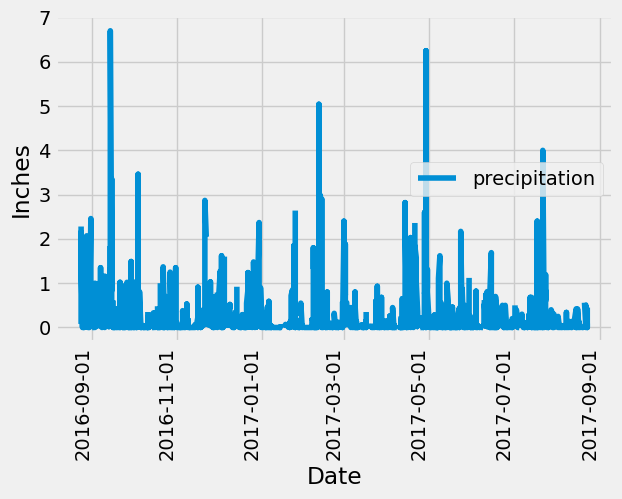

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
recent_date_str = recent_date[0]
# Starting from the most recent data point in the database. 
import matplotlib.dates as mdates
# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(recent_date_str, '%Y-%m-%d') - dt.timedelta(days=365)
print(f"The date one year ago from the most recent date is: {one_year_ago}")

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_precipitation = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the dataframe by date
df_precipitation['date'] = pd.to_datetime(df_precipitation['date'])  # Ensure 'date' is in datetime format
df_precipitation.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(6, 4))
df_precipitation.plot(x='date', y='precipitation', kind='line')
plt.xlabel('Date')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.ylabel('Inches')
plt.xticks(rotation=90)
#plt.tight_layout()
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
count_precipitation = df_precipitation['precipitation'].count()
mean_precipitation = df_precipitation['precipitation'].mean()
std_dev_precipitation = df_precipitation['precipitation'].std()
min_precipitation = df_precipitation['precipitation'].min()
quater_precipitation = df_precipitation['precipitation'].quantile(0.25)
median_precipitation = df_precipitation['precipitation'].median()
third_quarter_precipitation = df_precipitation['precipitation'].quantile(0.75)
max_precipitation = df_precipitation['precipitation'].max()
print ("\033[1m         precipation\033[0m")
print ("----------------------")
print("\033[1mcount\033[0m ", format(count_precipitation, ".6f"))
print("\033[1mmean\033[0m     ", format(mean_precipitation, ".6f"))
print("\033[1mstd\033[0m      ", format(std_dev_precipitation, ".6"))
print("\033[1mmin\033[0m      ", format(min_precipitation, ".6f"))
print("\033[1m25%\033[0m      ", format(quater_precipitation, ".6f"))
print("\033[1m50%\033[0m      ", format(median_precipitation, ".6f"))
print("\033[1m75%\033[0m      ", format(third_quarter_precipitation, ".6f"))
print("\033[1mMax\033[0m      ", format(max_precipitation, ".6f"))

         precipation
----------------------
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
Max       6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
stations = session.query(Base.classes.station).all()
total_stations = len(stations)
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(
    Base.classes.station.station,
    func.count(Base.classes.measurement.station)).join(Base.classes.measurement, Base.classes.station.station == Base.classes.measurement.station) \
 .group_by(Base.classes.station.station) \
 .order_by(func.count(Base.classes.measurement.station).desc()) \
 .all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Query to calculate the lowest, highest, and average temperature
results = session.query(
    func.min(Measurement.tobs).label('lowest_temperature'),
    func.max(Measurement.tobs).label('highest_temperature'),
    func.avg(Measurement.tobs).label('average_temperature')
).filter(Measurement.station == 'USC00519281').all()

# Print the results
for result in results:
    print(f"Lowest Temperature: {result.lowest_temperature}")
    print(f"Highest Temperature: {result.highest_temperature}")
    print(f"Average Temperature: {result.average_temperature}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


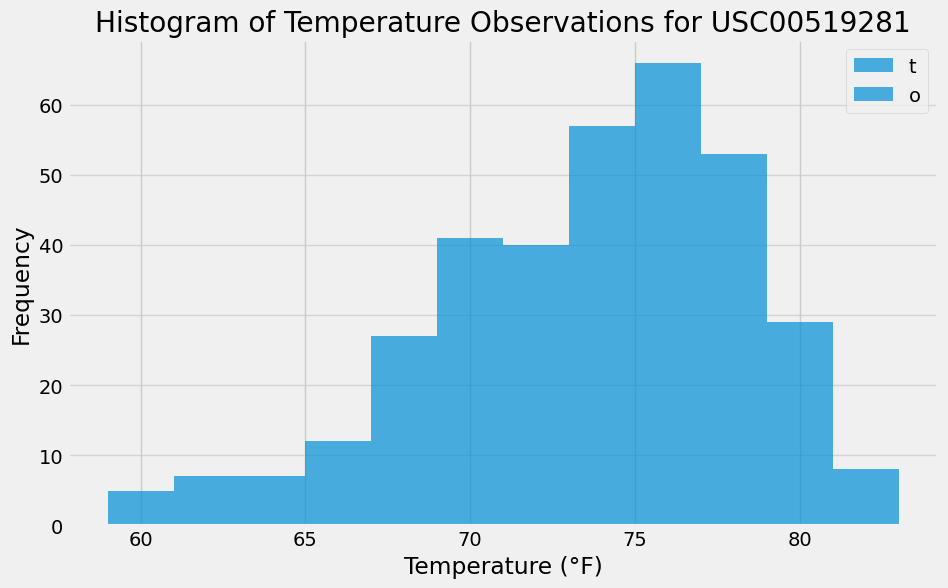

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
query = """
SELECT tobs
FROM measurement
WHERE station = 'USC00519281'
AND date >= DATE('2017-08-23', '-12 months')
"""
# Load the query results into a DataFrame
tobs_df = pd.read_sql(query, engine)
# Plot the results as a histogram
plt.figure(figsize=(10, 6))
tobs_df['tobs'].plot(kind='hist', bins=12, alpha=0.7, y='tobs')
plt.title('Histogram of Temperature Observations for USC00519281')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.legend("tobs",loc='best', fontsize='medium')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()